# Fruits Classifier

The goal of this notebook/project is to classify fruits based on the [fruits kaggle dataset](https://www.kaggle.com/datasets/moltean/fruits) using Pytorch🔥

To succesfully classify the images we'll need to accomplisht the following

1. View sampling of the images and get an understanding of how the variation in the images.
2. Collect and label the images. Currently, the labels for each image is the folder in which they are stored. Consequently, we'll need to organize them in a more suitable format.
3. Create a neural net to classify these images
4. Evaluate the performance of the neural net
5. Use a pretrained neural net to make predictions
6. Evaluate the pretrained neural net

In [1]:
!kaggle datasets download -d moltean/fruits

100%|█████████████████████████████████████▉| 1.28G/1.28G [02:10<00:00, 12.3MB/s]
100%|██████████████████████████████████████| 1.28G/1.28G [02:10<00:00, 10.6MB/s]


In [6]:
from zipfile import ZipFile
from pathlib import Path
import os

# Setup the title and create the data directory
TITLE = 'fruits'
title_zip = TITLE + '.zip'

# Set the data path
DATA_PATH = Path(os.path.join("..", "data", TITLE))
DATA_PATH.mkdir(parents=True, exist_ok=True)

# Open the zip file and extract to the datapath
if os.path.isfile(title_zip):
   with ZipFile(title_zip, 'r') as zipObj:
      zipObj.extractall(DATA_PATH)   
   # Remove the zip file once complete
   os.remove(title_zip)

In [2]:
# Base Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CompVision Imports
import cv2 as cv
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from torchvision import datasets, transforms
import torch.nn.functional as F

/Users/eliastavarez/opt/anaconda3/envs/jupyter39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
def get_image(fruit: str, position: int, train=True):
    dataset = 'Training' if train is True else 'Test'
    path = os.path.join(DATA_PATH, 'fruits-360_dataset', 'fruits-360', dataset, fruit)
    images = os.listdir(path)
    images_filtered = [img for img in images if img[0] != 'r']
    img = path + '/' + images_filtered[position]
    return cv.imread(img)

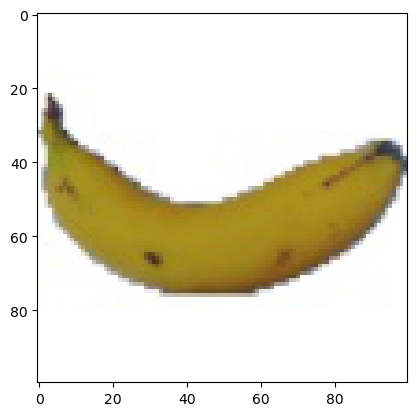

In [7]:
# Learning how to display an image
img = get_image('Banana', 2)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # the default for OpenCV is in BGR
plt.imshow(img)

For this project, I don't believe we need to manipulate the coloring of the images as that'll only hinder in the classification, so now we'll move onto preparing the data for pytorch.

In [8]:
# Labeling the different fruits
fruits_path = os.path.join(DATA_PATH, 'fruits-360_dataset', 'fruits-360', 'Training')
fruits = os.listdir(fruits_path)
fruit_df = pd.DataFrame(columns=['image', 'label'])
row_df = 0

for fruit in fruits:
    fruit_dir = fruits_path + '/' + fruit
    fruit_images = os.listdir(fruit_dir)
    fruit_images = [img for img in fruit_images if img[0] != 'r']
    for img in fruit_images:
        fruit_df.loc[row_df] = [fruit_dir + '/' + img, fruit]
        row_df += 1

In [9]:
fruit_df['img_arr'] = fruit_df['image'].apply(cv.imread)

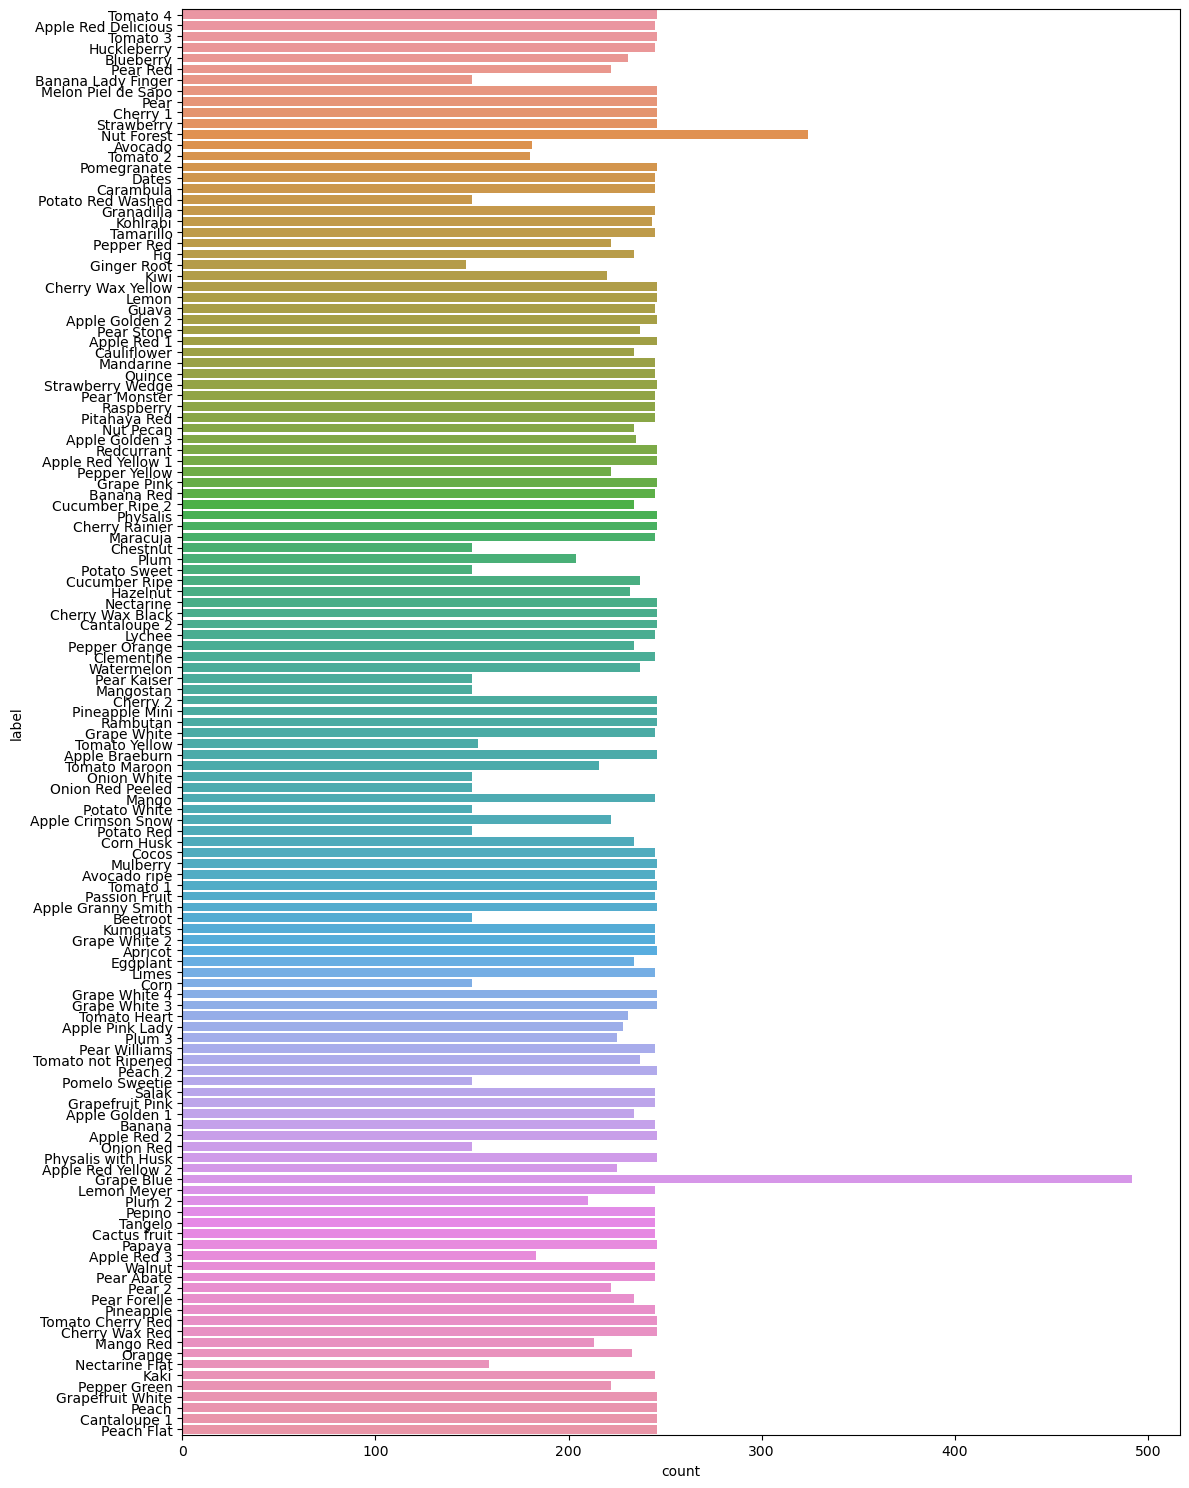

In [10]:
plt.figure(figsize=(12,15))
sns.countplot(y = fruit_df['label'])
plt.tight_layout()

In [11]:
# Get the total number of fruit labels
len(fruit_df['label'].unique())

131

## Loading the Data

In [12]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# Load the data
BATCH_SIZE = 32

train_path = os.path.join(DATA_PATH, 'fruits-360_dataset', 'fruits-360', 'Training')
test_path = os.path.join(DATA_PATH, 'fruits-360_dataset', 'fruits-360', 'Test')

train_dataset = datasets.ImageFolder(train_path, transform=transforms.ToTensor())
test_dataset = datasets.ImageFolder(test_path, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([32, 3, 100, 100]) torch.Size([32])


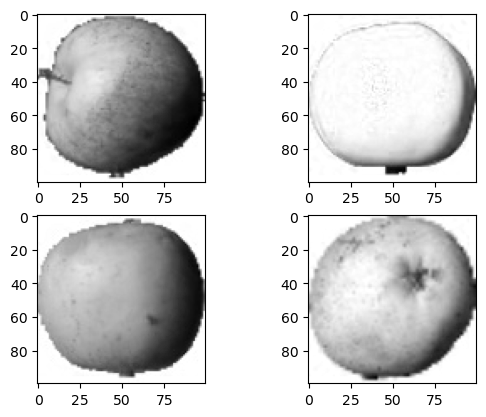

In [14]:
# Reviewing a couple of images
examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(samples[i][0], cmap='gray')

In [15]:
# Creating the CNN:
class ConvNet1(nn.Module):
    def __init__(self) -> None:
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*22*22, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 131)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
# Create a convolutional neural network
class ConvNet2(nn.Module):
    """
    Model architecture that replicates the TinyVGG model from CNN explainer website.
    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape, 
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),  # hyper-parmameters for CNNs
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units, 
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units*25*25,  # there's a trick to calculating this : )
                out_features=output_shape
            )
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x

model = ConvNet2(
    input_shape=3,
    hidden_units=10,
    output_shape=131
).to(device)

In [16]:
# Set Hyper-parameterse
NUM_EPOCHS = 4
LEARNING_RATE = 0.1

# Instantiaing the model, loss funciton and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [17]:
# Setting the number of total steps and running through the training loop
n_total_steps = len(train_loader)

# Training loop
for epoch in range(NUM_EPOCHS):
    # Set model to train mode
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # Send images to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Zero out the gradient
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Step through
        optimizer.step()
        
        if (i+1) % 500 == 0:
                print (f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/4], Step [200/2116], Loss: 4.8731
Epoch [1/4], Step [400/2116], Loss: 4.8646
Epoch [1/4], Step [600/2116], Loss: 4.8652
Epoch [1/4], Step [800/2116], Loss: 4.5858
Epoch [1/4], Step [1000/2116], Loss: 3.6311
Epoch [1/4], Step [1200/2116], Loss: 3.3610
Epoch [1/4], Step [1400/2116], Loss: 3.1712
Epoch [1/4], Step [1600/2116], Loss: 1.8868
Epoch [1/4], Step [1800/2116], Loss: 1.0471
Epoch [1/4], Step [2000/2116], Loss: 0.6195
Epoch [2/4], Step [200/2116], Loss: 0.2922
Epoch [2/4], Step [400/2116], Loss: 0.0299
Epoch [2/4], Step [600/2116], Loss: 0.2633
Epoch [2/4], Step [800/2116], Loss: 0.1505
Epoch [2/4], Step [1000/2116], Loss: 2.1889
Epoch [2/4], Step [1200/2116], Loss: 1.3896
Epoch [2/4], Step [1400/2116], Loss: 0.7899
Epoch [2/4], Step [1600/2116], Loss: 0.4682
Epoch [2/4], Step [1800/2116], Loss: 0.4584
Epoch [2/4], Step [2000/2116], Loss: 0.2229
Epoch [3/4], Step [200/2116], Loss: 0.0049
Epoch [3/4], Step [400/2116], Loss: 0.0315
Epoch [3/4], Step [600/2116], Loss: 0.0521

In [19]:
# Set the model to eval mode and use with_inference()
model.eval()
with torch.inference_mode():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:

        # Send the images to device
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc:.4f} %')

Accuracy of the network: 74.6915 %


Not great accuracy, but for a first pass with a custom built model, I'm happy to have gotten through the whole process with no errors!